In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
	sys.path.append(nb_dir)

In [2]:
import torch
import torch.nn as nn
from torch.optim.radam import RAdam

import matplotlib.pyplot as plt
import random
from tqdm import trange

from general_utils import AttrDict
from reward_induced.src.reward_predictor_model import RewardPredictorModel, R_CLASSES_BASE
from sprites_datagen.moving_sprites import MovingSpriteDataset
from sprites_datagen.rewards import *


/home/thisiswooyeol/anaconda3/envs/2024Spring/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=4,      # number of shapes per trajectory
        rewards=[AgentXReward, AgentYReward, TargetXReward, TargetYReward],
    )

In [4]:
dataset = MovingSpriteDataset(spec)
dataset[0]['rewards']

{'agent_x': array([0.33250925, 0.3556759 , 0.3788426 , 0.40200928, 0.42517594,
        0.44834262, 0.47150928, 0.49467596, 0.51784265, 0.5410093 ,
        0.564176  , 0.5873427 , 0.61050934, 0.63367605, 0.6568427 ,
        0.68000937, 0.7031761 , 0.72634274, 0.7495094 , 0.7726761 ,
        0.79584277, 0.8190094 , 0.84217614, 0.8653428 , 0.88850945,
        0.88832384, 0.8651572 , 0.84199053, 0.8188238 , 0.79565716],
       dtype=float32),
 'agent_y': array([0.8269267 , 0.87068504, 0.8855566 , 0.84179825, 0.79803985,
        0.7542815 , 0.7105231 , 0.6667648 , 0.62300646, 0.5792481 ,
        0.53548974, 0.49173138, 0.447973  , 0.40421465, 0.3604563 ,
        0.31669796, 0.2729396 , 0.22918123, 0.18542287, 0.1416645 ,
        0.10209385, 0.14585221, 0.18961056, 0.23336892, 0.27712727,
        0.32088563, 0.364644  , 0.40840235, 0.45216072, 0.49591905],
       dtype=float32),
 'target_x': array([0.58890444, 0.5892771 , 0.5896498 , 0.59002244, 0.5903951 ,
        0.59076774, 0.5911404 , 0.

# Train reward-induced representations with **RPM image encoder**

In [5]:
# some hyperparameters
image_shape = (3, 64, 64)
n_frames = 10  # number of conditioning frames
T_future = 20  # number of future frames to predict rewards for

lr = 1e-3
n_iter = 10_000
log_interval = 1_000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# # DEBUG - check computation graph of the model
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# from torchviz import make_dot

# model = RewardPredictorModel(image_shape, n_frames, T_future).to(device)
# image = dataset[0]['images']
# image = torch.tensor(image).to(device)
# pred_rewards = model(image[:n_frames].unsqueeze(0),
#                      image[n_frames:].unsqueeze(0))['agent_x']

# make_dot(pred_rewards, params=dict(model.named_parameters())).render('RPM_comp_graph', format='png')
# make_dot(pred_rewards, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render('RPM_comp_graph_back_prop', format='png')

In [7]:
def train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=True):
	losses = []
	model.to(device)
	print(f'[INFO] Training complete reward predictor model on device: {device} ...')

	for itr in trange(n_iter):
		# always call `gen_trajectory` method regardless of `itr`
		data = dataset[itr]
		images = torch.tensor(data.images).to(device)
		rewards = {k: torch.tensor(v, dtype=torch.float32, device=device) for k, v in data.rewards.items()}

		# considering incomplete reward annotations
		reward_type_list = random.sample(R_CLASSES_BASE, k=3) if not is_complete else R_CLASSES_BASE

		# predict rewards with RPM
		pred_rewards, _ = model(
			frames=images,
			reward_type_list=reward_type_list
		)

		# compute loss for each reward type
		loss = 0
		for reward_type, pred_reward in pred_rewards.items():
			reward = rewards[reward_type][-T_future:]
			loss += loss_fn(pred_reward, reward)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		losses.append(loss.item())
		if (itr+1) % log_interval == 0:
			print(f'[{itr+1} / {n_iter}] RPM loss: {loss.item()}')

	return losses

In [8]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

### (a) Train with complete reward annotation

In [9]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
loss_fn = nn.MSELoss()

optimizer = RAdam(model.parameters(), lr=lr)

In [10]:
losses_complete_reward = train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=True)

[INFO] Training complete reward predictor model on device: cuda ...


 10%|█         | 1005/10000 [00:27<03:49, 39.15it/s]

[1000 / 10000] RPM loss: 0.07580973953008652


 20%|██        | 2005/10000 [00:56<04:13, 31.50it/s]

[2000 / 10000] RPM loss: 0.08333932608366013


 30%|███       | 3005/10000 [01:26<03:26, 33.80it/s]

[3000 / 10000] RPM loss: 0.10045958310365677


 40%|████      | 4004/10000 [01:58<03:15, 30.68it/s]

[4000 / 10000] RPM loss: 0.12259286642074585


 50%|█████     | 5004/10000 [02:29<02:23, 34.76it/s]

[5000 / 10000] RPM loss: 0.03216881677508354


 60%|██████    | 6005/10000 [03:00<02:00, 33.18it/s]

[6000 / 10000] RPM loss: 0.17230141162872314


 70%|███████   | 7004/10000 [03:31<01:34, 31.83it/s]

[7000 / 10000] RPM loss: 0.05865514650940895


 80%|████████  | 8006/10000 [04:02<01:02, 31.74it/s]

[8000 / 10000] RPM loss: 0.07651465386152267


 90%|█████████ | 9003/10000 [04:33<00:30, 32.31it/s]

[9000 / 10000] RPM loss: 0.07448817789554596


100%|██████████| 10000/10000 [05:05<00:00, 32.75it/s]

[10000 / 10000] RPM loss: 0.06867115944623947


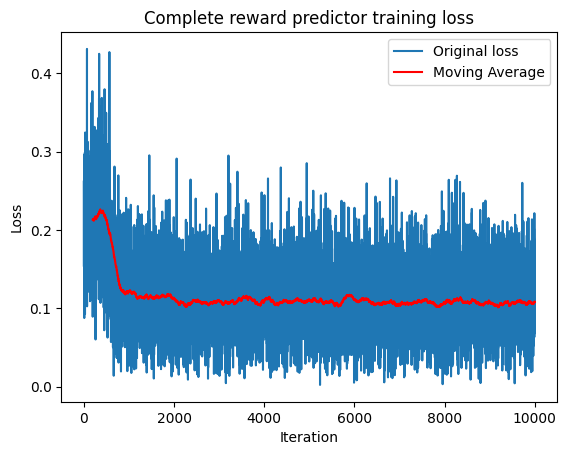

In [11]:
# Visualize the losses
window_size = 200
ma_losses = moving_average(losses_complete_reward, window_size)

plt.plot(losses_complete_reward, label='Original loss')
plt.plot(np.arange(window_size-1, len(ma_losses)+window_size-1), ma_losses, label='Moving Average', color='red')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Complete reward predictor training loss')
plt.legend()
plt.show()

In [12]:
PATH = 'models/complete_RPM_1e-3_1M.pth'
torch.save(model.state_dict(), PATH)

In [13]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(PATH))  # test save and load

<All keys matched successfully>

### (b) Train with incomplete reward annotation

In [14]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
loss_fn = nn.MSELoss()

optimizer = RAdam(model.parameters(), lr=lr)

In [15]:
losses_incomplete_reward = train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=False)

[INFO] Training complete reward predictor model on device: cuda ...


 10%|█         | 1004/10000 [00:29<04:10, 35.93it/s]

[1000 / 10000] RPM loss: 0.12175482511520386


 20%|██        | 2005/10000 [00:58<03:38, 36.56it/s]

[2000 / 10000] RPM loss: 0.049274034798145294


 30%|███       | 3005/10000 [01:27<03:11, 36.51it/s]

[3000 / 10000] RPM loss: 0.08561313152313232


 40%|████      | 4005/10000 [01:56<02:46, 36.06it/s]

[4000 / 10000] RPM loss: 0.0976649671792984


 50%|█████     | 5004/10000 [02:26<02:41, 30.98it/s]

[5000 / 10000] RPM loss: 0.04634124040603638


 60%|██████    | 6005/10000 [02:56<01:48, 36.99it/s]

[6000 / 10000] RPM loss: 0.10726937651634216


 70%|███████   | 7004/10000 [03:26<01:21, 36.67it/s]

[7000 / 10000] RPM loss: 0.08041027933359146


 80%|████████  | 8004/10000 [03:55<01:06, 30.23it/s]

[8000 / 10000] RPM loss: 0.08794198930263519


 90%|█████████ | 9004/10000 [04:26<00:36, 27.12it/s]

[9000 / 10000] RPM loss: 0.014873798005282879


100%|██████████| 10000/10000 [04:58<00:00, 33.54it/s]

[10000 / 10000] RPM loss: 0.06673869490623474


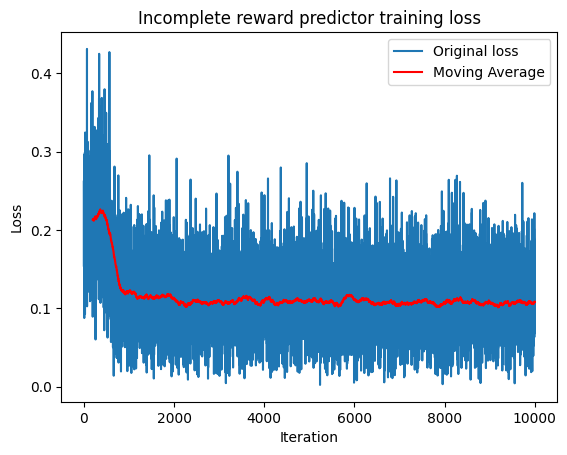

In [16]:
# Visualize the losses
window_size = 200
ma_losses = moving_average(losses_complete_reward, window_size)

plt.plot(losses_complete_reward, label='Original loss')
plt.plot(np.arange(window_size-1, len(ma_losses)+window_size-1), ma_losses, label='Moving Average', color='red')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Incomplete reward predictor training loss')
plt.legend()
plt.show()

In [17]:
PATH = 'models/incomplete_RPM_1e-3_1M.pth'
torch.save(model.state_dict(), PATH)

In [18]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(PATH))  # test save and load

<All keys matched successfully>